<html id="* graph_euler_method">
	<author>Hiroshi TAKEMOTO</author>
	(<email>take.pwave@gmail.com</email>)
	
	<h1>Sageでグラフを再現してみよう：データ解析のための統計モデリング入門第３章</h1>
	<p>
		この企画は、雑誌や教科書にでているグラフをSageで再現し、
		グラフの意味を理解すると共にSageの使い方をマスターすることを目的としています。
	</p>
	<p>
		前回に続き、<a href="http://www.amazon.co.jp/dp/400006973X/">データ解析のための統計モデリング入門</a>
		（以下、久保本と書きます）
		の第３章の例題をSageを使って再現してみます。
	</p>
	<p>
		数式処理システムSageのノートブックは、計算結果を表示するだけではなく、実際に動かすことができるの大きな特徴です。
		この機会にSageを分析に活用してみてはいかがでしょう。
	</p>
</html>

<html>
	<h2>前準備</h2>
	<p>
		最初に必要なライブラリーやパッケージをロードしておきます。jupyter用に新しくなったRUtil.pyも使います。
	</p>
</html>

In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="css/sage_table_form.css">

In [2]:
# RとPandasのデータフレームを相互に変換する関数を読み込む
# Rの必要なライブラリ
r('library(ggplot2)')
r('library(jsonlite)')

# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
load('script/sage_util.py')
# Rユーティリティ
load('script/RUtil.py')

<html>
	<h2>例題のデータ</h2>
	<p>
		３章の例題に使われているデータは、架空の植物の第i番目の個体のサイズ$x_i$と肥料の有無$f_i$が種子数$y_i$
		にどう影響するかを調べます。
		久保本の図３．１を以下に引用します。
	</p>
	<p>
		<img src="images/Fig3.1.png"/>
	</p>
	<p>
		３章のデータは、ネット公開されており、以下の例でもネットのデータを利用します。	
	</p>
	<p>
		データをロードしたら、summary関数とvar関数を使ってデータの素性を確認します。
		ここで、確認することは、以下の3項目です。
		<ul>
			<li>データの個数と欠損値の有無</li>
			<li>データの平均</li>
			<li>データの分散</li>
		</ul>
	</p>
</html>


In [3]:
# 3章のデータをネットから取り込む
d = pd.read_csv('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/poisson/data3a.csv')

<html>
	<h3>カテゴリ</h3>
	<p>
		肥料の有無（施肥$f_i$）は、CとTという文字列で表されており、Rでは因子（factor）と呼んでいますが、
		アンケートなどのカテゴリと言った方分かりやすいかも知れません。
	</p>
	<p>
		PandasのデータフレームもRのData.Frameに劣らず、$y_i$は整数型、$x_i$は実数型、$f_i$は因子型と扱ってくれます。
	</p>
</html>

In [4]:
# どんなデータか調べる
d.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [5]:
# 個数と平均、最大、最小を、標準偏差をみる
d.describe()

,y,x
count,100.000000,100.000000
mean,7.830000,10.089100
std,2.624881,1.008049
min,2.000000,7.190000
25%,6.000000,9.427500
50%,8.000000,10.155000
75%,10.000000,10.685000
max,15.000000,12.400000


<html>
	<h2>データの可視化</h2>
	<p>
		施肥の有無（C, T）別に種子種$y_i$とサイズ$x_i$の関係を散布図で表示してみます。
		seabornを使うと、このようなグラフも簡単に表示することができます。（施肥別の指定は、hue='f'で行っています）
	</p>
</html>

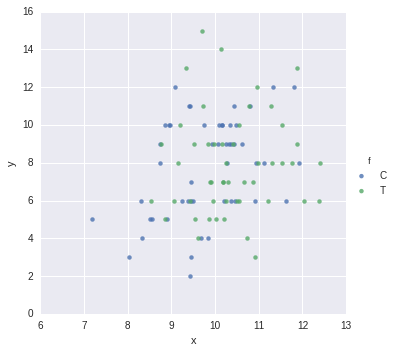

In [6]:
# F別の分布をみる
sns.lmplot('x', 'y', data=d, hue='f', fit_reg=False )
plt.show()

<html>
	<p>
		私は箱ひげ図には馴染みがなく、最初にみたときには驚きました。
		慣れてくるとばらつきを知るには良いプロット方法だと感じるようになりました。
	</p>
	<p>
		この分布の違いは、後で示す施肥別のヒストグラムをみると分かりやすいと思います。
	</p>
</html>

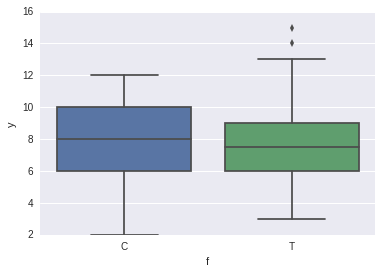

In [7]:
# F別の箱ひげ図
sns.boxplot(x='f', y='y', data=d)
plt.show()

<html>
	<h3>可視化から見えてくるもの</h3>
	<p>
		施肥別の散布図からは、久保本でも整理してあるとおり、
		<ul>
			<li>サイズxが増加すると共に種子数yが増えているように思える</li>
			<li>施肥fの効果はないように思われる</li>
		</ul>
		のように感じます。
	</p>
	<p>
		このようにデータを整理することが大切です。Sageでは処理と文章が1つのドキュメントにまとめられており、
		どのようにして結果を導いたのかを後から簡単にフォローすることができます。
	</p>
</html>


<html>
	<h3>施肥の違いをもう少しみてみる</h3>
	<p>
		PandasのデータフレームもRのData.Frame同様にデータの絞り込みができます。
	</p>
	<p>
		施肥のあるもの$f_T$を、以下の様にfのフィールドが'T"のものとして、d_Tにセットすることが1行で記述できます。
	<pre>
	d_T = d[d['f'] == 'T']		
	</pre>		
		また、Pandasでは、列（Series）をドット(.)で指定することもできるので、以下のようにも記述できます。
	<pre>
	d_T = d[d.f == 'T']	
	</pre>		
	</p>
</html>

In [8]:
# 施肥の有無の違いをみる
d_T = d[d['f'] == 'T']
d_T.describe()

,y,x
count,50.00000,50.000000
mean,7.88000,10.370600
std,2.65453,0.944307
min,3.00000,8.520000
25%,6.00000,9.757500
50%,7.50000,10.225000
75%,9.00000,10.947500
max,15.00000,12.400000


In [9]:
d_T.var()

y    7.046531
x    0.891716
dtype: float64

<html>
	<p>
		同様に施肥のないもの$f_C$を、抽出します。
	</p>
	<p>
		平均と分散がほぼ同じであることから、どちらもポアソン分布と仮定しても良さそうです。
	</p>
</html>

In [10]:
d_C = d[d['f'] == 'C']
d_C.describe()

,y,x
count,50.000000,50.000000
mean,7.780000,9.807600
std,2.620874,0.999813
min,2.000000,7.190000
25%,6.000000,9.115000
50%,8.000000,9.880000
75%,10.000000,10.412500
max,12.000000,11.930000


In [11]:
d_C.var()

y    6.868980
x    0.999627
dtype: float64

<html>
	<p>
		列の度数分布は、以下の様にgroupbyでy毎の頻度を求めることができます。
	</p>
</html>

In [12]:
# 施肥なし（C）の度数を調べる
d_C.groupby('y').size()

y
2      1
3      2
4      3
5      4
6     10
7      1
8      5
9      8
10     9
11     4
12     3
dtype: int64

<html>
	<h3>施肥別のヒストグラム</h3>
	<p>
		pandasのplot機能を使えば、施肥別のヒストグラムも以下の1行でプロットできます。
	</p>
	<p>
		byでfを指定することで施肥別のヒストグラムを図化できます。
	</p>
</html>

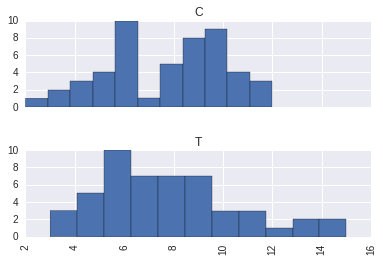

In [13]:
# F別のヒストグラムをみる
d.hist(column='y', by='f', sharex=True, layout=(2,1), bins=11)
plt.show()

<html>
	<h2>ポアソン回帰の統計モデル</h2>
	<p>
		施肥別の平均、分散からも$個体_i$の種子数$y_i$の確率$p(y_i | \lambda_i)$は、ポアソン分布に従うとして、
		以下の式で表します。
$$
		p(y_i | \lambda_i) = \frac{\lambda_i^{y_i}exp(-\lambda_i)}{y_i!}
$$		
	</p>
</html>

<html>
	<h3>$個体_iの平均種子数\lambda_i$の式</h3>
	<p>
		久保本の3.4.1では、$個体_iの平均種子数\lambda_i$を以下の様な指数関数で表しています。
$$
		\lambda_i = exp( \beta_1 + \beta_2 x_i)
$$		
	</p>
	<p>
		ここで、$\beta_1, \beta_2$は、式を決定づけるパラメータです。図3.4では、このパラメータを変えることで、
		どうような曲線になるか示しています。これをSageを使って表示すると以下のようになります。
	</p>
	<p>
		直線よりも指数関数の表現力があるようにみえます。
	</p>
</html>

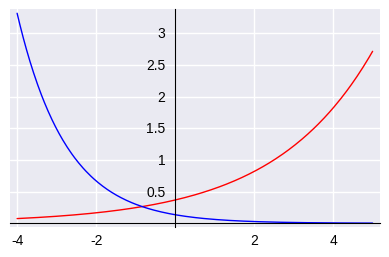

In [14]:
# fig3.4
p1 = plot(lambda x: exp(-1+0.4*x), [x, -4, 5], rgbcolor='red')
p2 = plot(lambda x: exp(-2-0.8*x), [x, -4, 5], rgbcolor='blue')
(p1 + p2).show(figsize=4)

<html>
	<h3>線形予測子とリンク関数</h3>
	<p>
		glmで使われるリンク関数と線形予測子の関係を整理すると以下の様になります。
		線形予測子は、パラメータが線形結合しているもので、ターゲットとなる変数
		（ここでは$\lambda_i$）を線形予測子で表したときに、以下の関係がある場合、
$$
		\lambda_i = f(線形予測子)
$$		
		リンク関数は、fの逆関数を使って以下の関係にあります。
$$
		f^{-1}(\lambda_i) = (線形予測子)
$$		
	</p>
	<p>
		ですから指数関数で表された$\lambda_i$のリンク関数は、対数を使って以下の様になります。
$$
		log \lambda_i = \beta_1 + \beta_2 x_i
$$		
	</p>
</html>

<html>
	<h3>ポアソン回帰の実行</h3>
	<p>
		久保本では、モデルから推定される予測の良さを重視しており、その指標として対数尤度が最大になることを目安としています。
	</p>
	<p>
		今回のデータに対する対数尤度(Log-Likelihood)は、以下の様になります。この対数尤度の最大値を追求することになります。
$$
		log L(\beta_1, \beta_2) = \sum_i log \frac{\lambda_i^{y_i} exp(\lambda_i)}{y_i !}
$$		
	</p>
	<p>
		ここでは、Pythonのstatsmodelsパッケージを使ってGLM（一般化線型モデル）を使ってポアソン回帰を行います。
	</p>
</html>

In [15]:
# statsmodelsを使ってglmを計算します
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr

<html>
	<h3>glmの引数</h3>
	<p>
		glmの引数について説明すると、
		<ul>
			<li>fit: 回帰の結果をセットする変数</li>
			<li>y ~ x: モデル式を線形予測子で表現します</li>
			<li>data: dでデータフレームを指定します</li>
			<li>family: sm.families.Poissonで確率分布としてポアソン分布を指定します</li>
			<li>link: sm.families.links.logで対数を指定します</li>
			<li>fit(): 最後にfit関数で回帰を計算します</li>
		</ul>
	</p>
	<p>
		回帰の結果は、summary2関数で表示します。結果は、
		<ul>
			<li>対数尤度(Log-Likelihood): -235.39</li>
			<li>逸脱度(deviance): 84.993</li>
			<li>切片$\beta_1$(Intercept): 1.2917、標準誤差は0.3637</li>
			<li>xの係数$\beta_2$: 0.0757、標準誤差は0.0356</li>
		</ul>
		と求まります。
	</p>
</html>

In [16]:
fit = smf.glm('y ~ x', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()
fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            474.7725 
Link Function:      log              BIC:            -366.3137
Dependent Variable: y                Log-Likelihood: -235.39  
Date:               2016-07-17 01:38 LL-Null:        -237.64  
No. Observations:   100              Deviance:       84.993   
Df Model:           1                Pearson chi2:   83.8     
Df Residuals:       98               Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      1.2917    0.3637  3.5517  0.0004  0.5789  2.0045
x              0.0757    0.0356  2.1251  0.0336  0.0059  0.1454
==============================================================

"""

In [17]:
# 逸脱度→deviance, 対数尤度logLik→llf, AIC→aicにセットされている
print fit.deviance, fit.llf, fit.aic

84.9929964907 -235.38625077 474.77250154


<html>
	<h3>回帰結果のプロット</h3>
	<p>
		λの予測値は、predict関数で取得することができます（fitのnuにセットされているみたいです）。
	</p>
	<p>
		施肥別の分布図に予測値を重ね書きします。
		予測値をyhatにセットし、pandasでソートした後、lineplotします。
	</p>
</html>

In [18]:
# λの予測値nuをyhatにセット
d['yhat'] = fit.predict()

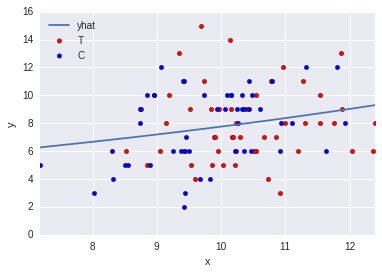

In [19]:
ax = d.sort_values(by=['x']).plot(x='x', y='yhat')
d_T.plot(kind='scatter', x='x', y='y', c='r', ax=ax, label='T')
d_C.plot(kind='scatter', x='x', y='y', c='b', ax=ax, label='C')
plt.legend(loc='upper left')
plt.show()

<html>
	<h3>施肥処理Fをモデルに組み込む</h3>
	<p>
		つぎに施肥処理fを使ってポアソン回帰をしてみましょう。xと異なりfには数字では無くT, Cのような文字列（因子型）が入っています。
	</p>
	<p>
		因子型で線形予測子を作る場合、因子の数より1個少ない数の$d_i$というダミー変数を使って、因子の影響を線形予測子として表します。
		$d_i$が、$f_i=T$の場合1， $f_i!=T$の場合0とします。因子型ではいずれか一つの因子に当てはまる（昔のカーラジオのボタンのように）
		としているので、$f_i$がTでなければCとなるので、因子がTとCの2個の場合ダミー変数は、$d_i$1個で足ります。
	</p>
<p>
		もし、肥料が複数の場合には、ダミー変数は、$d_i,A, d_i,B, d_i,C$のように複数作らなくてはなりません。
	</p>
	<p>
		glmは、とてもお利口なので人がダミー変数を指定する代わりに因子型の変数fを指定するだけで内部的にダミー変数を考慮した計算をしてくれます。
	</p>
	<p>
		モデル式をy ~ xからy ~ fに変えてポアソン回帰を実行してみます。
	</p>
	<p>
		回帰の結果は、summary2関数で表示します。結果は、
		<ul>
			<li>対数尤度(Log-Likelihood): -237.63</li>
			<li>逸脱度(deviance): 89.475</li>
			<li>切片$\beta_1$(Intercept): 2.0516、標準誤差は0.0507</li>
			<li>fの係数$\beta_3$: 0.0128、標準誤差は0.0715</li>
		</ul>
		先の例と比べると、対数尤度は-237.63と小さく求まっています。
	</p>
	<p>
		久保本は、とても丁寧でこの結果をどう考えるかを解説してくれています。
$$
		\lambda_i = exp(2.05 + 0.0128) = exp(2.05) exp(0.0128)
$$	
		施肥を行った場合には、施肥を行わない場合（0.0128の項が０）の1.0128倍に若干増えると予測しています。
$$
		\lambda_i = exp(2.05 + 0.0128) = 1.0128 exp(2.05) 
$$	
	</p>
</html>

In [20]:
# 施肥処理Fをモデルに組み込む
fit_f= smf.glm('y ~ f', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()
fit_f.summary2() 

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            479.2545 
Link Function:      log              BIC:            -361.8317
Dependent Variable: y                Log-Likelihood: -237.63  
Date:               2016-07-17 01:38 LL-Null:        -237.64  
No. Observations:   100              Deviance:       89.475   
Df Model:           1                Pearson chi2:   87.1     
Df Residuals:       98               Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
---------------------------------------------------------------
Intercept    2.0516    0.0507  40.4630  0.0000   1.9522  2.1509
f[T.T]       0.0128    0.0715   0.1787  0.8582  -0.1273  0.1529
==============================================================

"""

<html>
	<h2>個体のサイズと施肥を合わせたモデル</h2>
	<p>
		最後に個体のサイズ$x_i$と施肥$f_i$を合わせたモデルを使ってポアソン回帰を行ってみます。
	</p>
	<p>
		モデル式は、y ~ x + fとなります。
	</p>
	<p>
		結果は以下の様になります。
$$
		\lambda_i = 1.26 + 0.08 x_i - 0.032
$$		
	</p>
</html>

In [21]:
# 説明変数が数量型＋因子型のモデル
fit_all = smf.glm('y ~ x + f', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()
fit_all.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            476.5874 
Link Function:      log              BIC:            -361.8936
Dependent Variable: y                Log-Likelihood: -235.29  
Date:               2016-07-17 01:38 LL-Null:        -237.64  
No. Observations:   100              Deviance:       84.808   
Df Model:           2                Pearson chi2:   83.8     
Df Residuals:       97               Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025  0.975]
---------------------------------------------------------------
Intercept    1.2631    0.3696   3.4172  0.0006   0.5386  1.9876
f[T.T]      -0.0320    0.0744  -0.4302  0.6670  -0.1778  0.1138
x            0.0801    0.0370   2.1620  0.0306   0.0075  0.1527
==============================================================

"""

<html>
	<h3>Nullモデルとの比較</h3>
	<p>
		ついでなので、λが定数の場合（Nullモデル）のポアソン回帰の結果を以下に示します。
	</p>
	<p>
		ここで注目するのは、Log-Likelihoodの値-237.64です。
		λが定数の場合の対数尤度と自分の考えたモデルの対数尤度を比べることで、
		自分のモデルがどの程度よいのか比較できることです。
	</p>
</html>

In [22]:
# Nullモデルの逸脱度とAIC
fit_null = smf.glm('y ~ 1', data=d, family=sm.families.Poisson(link=sm.families.links.log)).fit()
fit_null.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            477.2864 
Link Function:      log              BIC:            -366.4049
Dependent Variable: y                Log-Likelihood: -237.64  
Date:               2016-07-17 01:38 LL-Null:        -237.64  
No. Observations:   100              Deviance:       89.507   
Df Model:           0                Pearson chi2:   87.1     
Df Residuals:       99               Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept     2.0580    0.0357  57.5862  0.0000  1.9879  2.1280
==============================================================

"""

In [23]:
# 逸脱度→deviance, 対数尤度logLik→llf, AIC→aicにセットされている
print fit_null.deviance, fit_null.llf, fit_null.aic

89.5069375696 -237.643221309 477.286442619


<html>
	<h2>3章注目のグラフ</h2>
	<p>
		「Sageでグラフを再現してみよう」ではいろんなグラフをSageで再現してその本質を理解できるように挑戦しています。
	</p>	
	<p>
		3章の注目のグラフは、図3.9（以下久保本から引用します）の（Ｂ）です。
		種子数λがサイズxに対して指数関数で増加するとそのポアソン分布は裾野が広く平らに分布しています。
		今回はこのグラフをSageを使って計算してみます。
	</p>
	<p>
		<img src="images/Fig3.9.png"/>
	</p>
	<p>
		GLMの結果が示されていないので、$x$が0.5, 1.1, 1.7のyの値をグラフから読み取り、
		0.1, 0.5, 3.0としてポアソン分布をプロットしたのが、以下の図です。図３．９（Ｂ）のポアソン分布
		とよく似た分布になっています。
	</p>
	
</html>

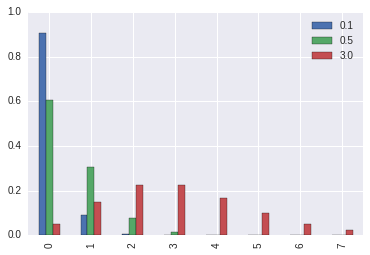

In [24]:
# 3章のメインのグラフは、図3.9だと思う。
# 0.5, 1.1, 1.7のyを0.1, 0.5, 3.0としてポアソン分布を表示
# Fig. 2.6
# ポアソン関数p(y, λ)を定義
def p(y, lam):
    return float(lam^y*e^(-lam)/factorial(y) )
# データフレームを作成
df = pd.DataFrame(
    {
        '0.1': [p(y, 0.1) for y in range(8)],
        '0.5': [p(y, 0.5) for y in range(8)],
        '3.0': [p(y, 3.0) for y in range(8)]
    })
# データフレームのプロット
df.plot.bar()
plt.show()